In [81]:
# Import libraries
%matplotlib inline

import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale
import pysal as ps

sns.set(style="whitegrid")

In [82]:
# Import data
broker_data = 'data/Brokered2018_zipcodes.csv'
coord = 'data/states.json'


In [83]:
# Read data
broker = pd.read_csv(broker_data)
broker.head()

,Order #,Leg #,Start Date,Agent Office,Cust ID,Customer,Carrier ID,Carrier,Origin City,OriginState,Destination City,Destination State,Brokered Revenue,Carrier Pay,Brokered Margin,Brokered Margin %,Booking Agent ID,Booking Agent
0,1361713,1349039,8/15/18,1,AMNP,AMNP,43708,43708,San Antonio,Texas,Palmyra,Wisconsin,"$2,500.00","$2,400.00",$100.00,4.00%,KAILA,1
1,1501026,1542730,1/30/18,1,AMNP,AMNP,442007,442007,Hammond,Indiana,Denver,Colorado,"$3,050.00","$2,950.00",$100.00,3.27%,KAILA,1
2,1518714,1567360,1/5/18,1,AMNP,AMNP,971955,971955,Denver,Colorado,Meridian,Idaho,"$1,200.00","$1,200.00",$-,0.00%,ZABCA,2
3,1538821,1595101,4/2/18,1,AMNP,AMNP,355478,355478,Jewett,Texas,Hartford,South Dakota,"$2,000.00","$1,900.00",$100.00,5.00%,KAILA,1
4,1601007,1680031,8/22/18,1,AMNP,AMNP,184749,184749,Bismarck,North Dakota,Marion,Ohio,"$2,300.00","$2,200.00",$100.00,4.34%,KAILA,1


In [84]:
broker['Start Date'] =  pd.to_datetime(broker['Start Date'])

In [85]:
print(broker['Start Date'])

0        2018-08-15
1        2018-01-30
2        2018-01-05
3        2018-04-02
4        2018-08-22
            ...    
213739   2021-05-28
213740   2021-05-28
213741   2021-05-31
213742   2021-05-31
213743   2021-05-31
Name: Start Date, Length: 213744, dtype: datetime64[ns]


In [86]:
# Find the max date in the data set for rolling 12 month
endDate = broker['Start Date'].max()
endDate

Timestamp('2021-05-31 00:00:00')

In [87]:
# Rolling date start point
startDate = endDate - pd.DateOffset(years=1)
startDate

Timestamp('2020-05-31 00:00:00')

In [88]:
#filter out data prior to start date to have rolling 12 months; rename origin column to state
filteredBroker = broker.loc[(broker['Start Date'] >= startDate)]
filteredBroker.rename(columns = {'OriginState':'NAME'}, inplace = True)


for col in filteredBroker.columns:
    print(col)
    
filteredBroker

Order #
Leg #
Start Date
Agent Office
Cust ID
Customer
Carrier ID
Carrier
Origin City
NAME
Destination City
Destination State
Brokered Revenue
Carrier Pay
Brokered Margin
Brokered Margin %
Booking Agent ID
Booking Agent


/Users/shannagreathouse/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Order #,Leg #,Start Date,Agent Office,Cust ID,Customer,Carrier ID,Carrier,Origin City,NAME,Destination City,Destination State,Brokered Revenue,Carrier Pay,Brokered Margin,Brokered Margin %,Booking Agent ID,Booking Agent
131033,2039632,2219540,2021-04-27,1,AMNP,AMNP,155298,155298,Saint Paul,Minnesota,Bottineau,North Dakota,"$1,600.00","$1,500.00",$100.00,6.25%,HERRO,4
142166,2069107,2258289,2020-06-19,5,CONELP,CONELP,775727,775727,Heyburn,Idaho,Council Bluffs,Iowa,"$2,150.56","$1,700.00",$450.56,20.95%,MELMI,9
144595,2075503,2266726,2020-06-01,17,FAMMAU,FAMMAU,70282,70282,Rolesville,North Carolina,Cowpens,South Carolina,$521.74,$500.00,$21.74,4.16%,OCASO,104
144596,2075504,2266727,2020-06-08,17,FAMMAU,FAMMAU,70282,70282,Rolesville,North Carolina,Cowpens,South Carolina,$521.74,$500.00,$21.74,4.16%,OCASO,104
144598,2075506,2266729,2020-06-08,17,FAMMAU,FAMMAU,673535,673535,Rolesville,North Carolina,Cowpens,South Carolina,$-,$150.00,($150.00),0.00%,OCASO,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213739,2341809,2586585,2021-05-28,10,MONEAS,MONEAS,TX6877A,TX6877A,Houston,Texas,Houston,Texas,"$1,200.00","$1,000.00",$200.00,16.66%,QUITHO,39
213740,2347760,2593593,2021-05-28,16,CHICHA,CHICHA,770152,770152,New Castle,Delaware,Wilmington,Delaware,$143.96,$-,$143.96,100.00%,UNKNOWN,6
213741,2347761,2593594,2021-05-31,16,CHICHA,CHICHA,770152,770152,New Castle,Delaware,Wilmington,Delaware,$143.96,$-,$143.96,100.00%,UNKNOWN,6
213742,2347762,2593595,2021-05-31,16,CHICHA,CHICHA,770152,770152,New Castle,Delaware,Wilmington,Delaware,$143.96,$-,$143.96,100.00%,UNKNOWN,6


In [89]:
# Variables maintained
varis = ['Agent Office', 'Booking Agent','Carrier']

In [90]:
#Group data by state
states = filteredBroker.groupby('NAME')[varis].describe()
states

Agent Office                                                \
                      count       mean        std   min   25%   50%   75%   
NAME                                                                        
Alabama               185.0  15.410811   2.511688   3.0  14.0  17.0  17.0   
Arizona               506.0  18.687747   4.856895   5.0  17.0  17.0  22.0   
Arkansas              283.0  12.692580   3.021351   5.0  13.0  13.0  13.0   
California           4740.0   9.539873   6.107662   4.0   5.0   5.0  12.0   
Colorado             1019.0  11.452404   3.127362   1.0  12.0  12.0  12.0   
Connecticut           943.0   9.563097   0.755725   3.0   9.0  10.0  10.0   
Delaware            12396.0  15.944418   0.712177   3.0  16.0  16.0  16.0   
Florida              2344.0  16.707765   2.446423   3.0  17.0  17.0  17.0   
Georgia               755.0  13.651656   4.664526   4.0   9.0  14.0  17.0   
Idaho                 105.0  14.628571  11.988181   3.0   4.0   5.0  29.0   
Illinois             2203.0  12.574671   5.276396   1.0   9.0  14.0  14.0   
Indiana               734.0  12.152589   7.821239   4.0   6.0   9.0  14.0   
Iowa                  878.0  10.105923   2.911298   1.0   9.0   9.0  14.0   
Kansas                735.0   9.398639   1.965714   5.0   9.0   9.0   9.0   
Kentucky              199.0  14.211055   4.014579   4.0   9.0  17.0  17.0   
Louisiana             919.0   9.307943   1.894796   4.0  10.0  10.0  10.0   
Maine                 192.0   6.593750   1.963425   3.0   6.0   6.0   6.0   
Maryland              480.0  12.212500   3.976530   4.0   9.0  10.0  17.0   
Massachusetts          88.0   7.613636   3.878712   3.0   4.0   9.0   9.0   
Michigan              273.0   9.780220   4.185415   1.0   9.0   9.0  14.0   
Minnesota             773.0   7.419146   6.879627   1.0   1.0   4.0   9.0   
Mississippi            19.0  14.684211   1.796683  14.0  14.0  14.0  14.0   
Missouri              304.0   9.282895   5.098913   3.0   6.0   9.0   9.0   
Montana                 1.0  14.000000        NaN  14.0  14.0  14.0  14.0   
Nebraska               14.0   4.357143   6.651861   1.0   1.0   1.0   4.0   
Nevada                 54.0  17.092593   4.257152   5.0  14.0  14.0  22.0   
New Hampshire          39.0   7.846154   1.478592   6.0   6.0   9.0   9.0   
New Jersey           1736.0   6.889977   3.791845   3.0   6.0   6.0   9.0   
New Mexico             97.0  11.505155   1.659089   6.0  12.0  12.0  12.0   
New York             8214.0   8.112856   2.691681   3.0   6.0   9.0   9.0   
North Carolina       2303.0  13.513244   3.234490   1.0  10.0  14.0  17.0   
North Dakota          112.0   2.223214   3.206721   1.0   1.0   1.0   1.0   
Ohio                  809.0   8.269468   3.887218   1.0   5.0   9.0   9.0   
Oklahoma              193.0   8.124352   3.174619   1.0   4.0  10.0  10.0   
Oregon                805.0   6.591304   2.811344   4.0   5.0   5.0   9.0   
Pennsylvania         7660.0   9.190470   4.212422   1.0   6.0   8.0   9.0   
Rhode Island          178.0   8.797753   1.085912   3.0   9.0   9.0   9.0   
South Carolina        489.0  15.732106   2.491751   6.0  16.0  17.0  17.0   
South Dakota           40.0   2.600000   4.093773   1.0   1.0   1.0   1.0   
Tennessee             647.0  11.950541   3.266401   1.0  11.0  13.0  13.0   
Texas                4099.0  10.714808   7.717461   1.0   4.0   4.0  21.0   
Utah                  817.0   7.776010   2.753787   1.0   5.0   9.0   9.0   
Vermont                13.0  12.076923   3.839738   4.0  14.0  14.0  14.0   
Virginia             2189.0  12.354957   1.942642   3.0  13.0  13.0  13.0   
Washington            339.0   6.103245   3.855138   4.0   5.0   5.0   5.0   
West Virginia          50.0   9.000000   0.000000   9.0   9.0   9.0   9.0   
Wisconsin            1629.0  15.295273   7.443356   1.0   9.0  14.0  26.0   
Wyoming                 7.0   1.000000   0.000000   1.0   1.0   1.0   1.0   

                     Booking Agent                                            \
       

In [91]:
#Group by customers and convert to binary
types = pd.get_dummies(filteredBroker['Customer'])
region_types = types.join(filteredBroker['NAME'])\
                  .groupby('NAME')\
                  .sum()
region_types_pct = (region_types * 100.).div(region_types.sum(axis=1), axis=0)
region_types_pct.info()
region_types_pct

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Alabama to Wyoming
Columns: 397 entries, 3MCFOR to ZIMLYN
dtypes: float64(397)
memory usage: 149.2+ KB


,3MCFOR,3MCSAI02,ABCBEL01,ABCNOV,ADMDEC,ADMDEC07,AESNOG,AFBU,AFPB,AFVRO,...,WWBO02,WWRO,XPOANN,XPOCHA,XPOPOR,YELCHE01,YOUCAN,ZAVSTE,ZAVSTE01,ZIMLYN
NAME,,,,,,,,,,,,,,,,,,,,,
Alabama,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Arizona,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.976285,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.592885,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Arkansas,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
California,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.168776,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.084388,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Colorado,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Connecticut,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Delaware,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.994514,0.000000,0.129074,0.05647,0.000000
Florida,0.000000,0.000000,0.000000,0.042662,0.000000,0.000000,0.213311,0.000000,0.213311,2.474403,...,0.042662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Georgia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.264901,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.132450,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [92]:
# Combine data sets
region_props = pd.merge(states, region_types, on=["NAME"])

/Users/shannagreathouse/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [93]:
#Scale 
#db = pd.DataFrame(\
 #                scale(region_props), \
  #               index=region_props.index, \
   #              columns=region_props.columns)\
    #   .rename(lambda x: str(int(x)))
db = region_props

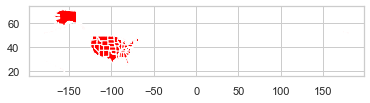

In [94]:
# bring in geojson dataframe
usMap = gpd.read_file(coord)
usMap.plot(color='red');

In [97]:
# match geojson dataframe and broker_data on 'state'
statedb = usMap[['geometry', 'STATE', 'NAME']].join(db, on='NAME')\
                                         .dropna()

In [98]:
#Optimal Cluster Calculations
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(statedb)
    Sum_of_squared_distances.append(km.inertia_)

ValueError: setting an array element with a sequence.

In [99]:
#Cluster in specfic groups
cluster_count = 5
km5 = cluster.KMeans(n_clusters=cluster_count)

In [100]:
# Fit to data
km5cls = km5.fit(statedb.drop(['geometry', 'NAME'], axis=1).values)

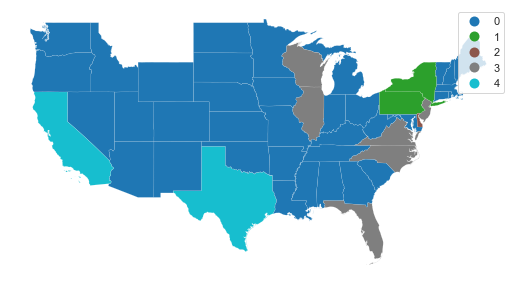

In [104]:
# Map clusters
f, ax = plt.subplots(1, figsize=(9, 9))

statedb.assign(cl=km5cls.labels_)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

Regions = plt.show()
Regions

In [111]:
#Bind to html
result = Regions.to_html()
print(result)

AttributeError: 'NoneType' object has no attribute 'to_html'

In [112]:
html = Regions.to_html()
# write html to file
text_file = open("index.html", "w")
text_file.write(html)
text_file.close()

AttributeError: 'NoneType' object has no attribute 'to_html'

In [102]:
# Attributes
cl_pcts = region_types_pct.rename(lambda x: str(int(x)))\
                          .reindex(statedb['NAME'])\
                          .assign(cl=km5cls.labels)\
                          .groupby('cl')\
                          .mean()

ValueError: invalid literal for int() with base 10: 'Alabama'

NameError: name 'cl_pcts' is not defined

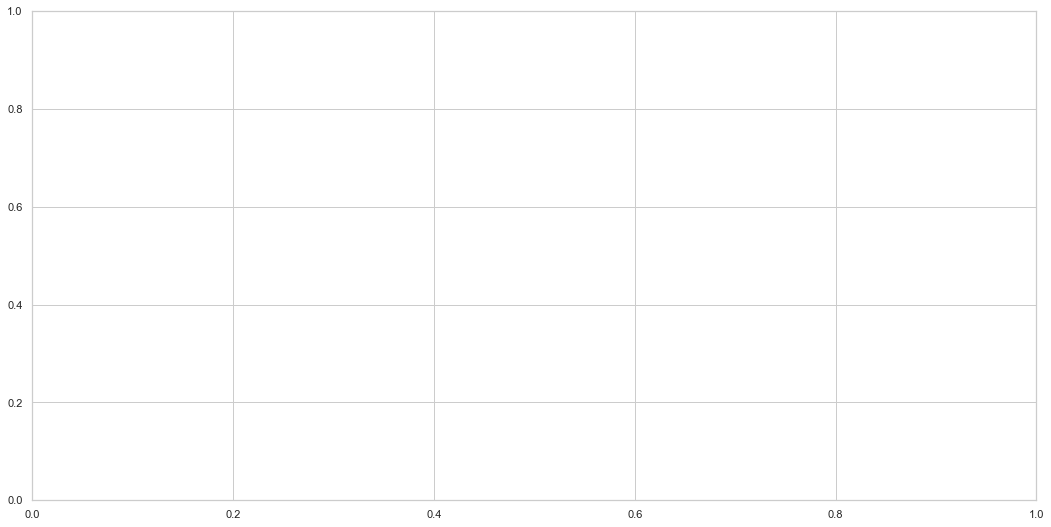

In [103]:
#Visualize attributes and mix
f, ax = plt.subplots(1, figsize=(18, 9))
cl_pcts.plot(kind='barh', stacked=True, ax=ax, \
             cmap='Set2', linewidth=0)
ax.legend(ncol=1, loc="right");

In [ ]:
# Add layer to balance load volume and remove enterprise accounts